# NNet class in Pytorch

In this assignment you will complete an implementation of a neural network class that uses `pytorch`.  You will then use it to conduct some training experiments on specified data.  The data will be partitioned into some number of non-intersecting folds.  You will train, validate and test neural networks of various sizes on all ways of picking one fold to be testing, one fold to be validation, and remaining folds to be training sets.

## Implementation

In [2]:
import numpy as np
import torch
import pandas
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

Complete the following definition of class `NNet` by completing its `train` and `use` functions.  These functions must be completed the *PyTorch* way, which is **not** identical to how you completed the network in A2 (though the same principles apply)!

In [16]:
class NNet(torch.nn.Module):
    
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, act_func='tanh', use_gpu=False):
        super().__init__()  # call parent class (torch.nn.Module) constructor
        
        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        self.hidden_layers = torch.nn.ModuleList()  # necessary for model.to('cuda')

        for nh in self.n_hiddens_per_layer:
            self.hidden_layers.append( torch.nn.Sequential(
                torch.nn.Linear(n_inputs, nh),
                torch.nn.Tanh() if act_func == 'tanh' else torch.nn.ReLU()))
            
            n_inputs = nh

        self.output_layer = torch.nn.Linear(n_inputs, n_outputs)
            
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None

        self.error_trace = []
        
        self.use_gpu = use_gpu
        if self.use_gpu:
            self.to('cuda')
        
    def forward(self, X):
        Y = X
        for hidden_layer in self.hidden_layers:
            Y = hidden_layer(Y)
        Y = self.output_layer(Y)
        return Y

    def train(self, X, T, n_epochs, learning_rate, verbose=True):

        # Set data matrices to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
        if not isinstance(T, torch.Tensor):
            T = torch.from_numpy(T).float()
        
        if self.use_gpu:
            X = X.to('cuda')
            T = T.to('cuda')
        
        # Calculate standardization parameters if not already calculated
        if self.Xmeans is None:
            self.Xmeans = X.mean(0)
            self.Xstds = X.std(0)
            self.Xstds[self.Xstds == 0] = 1
            self.Tmeans = T.mean(0)
            self.Tstds = T.std(0)
            self.Tstds[self.Tstds == 0] = 1
            
        # Standardize inputs and targets
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds
        
        # Set optimizer to Adam and loss functions to MSELoss
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        mse_func = torch.nn.MSELoss()

        # For each epoch:
        #   Do forward pass to calculate output Y.
        #   Calculate mean squared error loss, mse.
        #   Calculate gradient of mse with respect to all weights by calling mse.backward().
        #   Take weight update step, then zero the gradient values.
        #   Unstandardize the mse error and save in self.error_trace
        #   Print epoch+1 and unstandardized error if verbose is True and
        #             (epoch+1 is n_epochs or epoch+1 % (n_epochs // 10) == 0)
        
        for epoch in range(n_epochs):

            Y = self.forward(X)
            
            mse = mse_func(T, Y)
            mse.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            rmse = torch.sqrt(mse) * self.Tstds
            self.error_trace.append(rmse)
            
            
            if verbose and (epoch + 1 == n_epochs or (epoch + 1) % (n_epochs // 10) == 0):
                print(f'Epoch {epoch + 1}: RMSE {rmse:.3f}')

    def use(self, X):
 
       # Set input matrix to torch.tensors if not already.
        if not isinstance(X, torch.Tensor):
            X = torch.from_numpy(X).float()
            
        if self.use_gpu:
            X = X.to('cuda')

        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        
        # Do forward pass and unstandardize resulting output. Assign to variable Y.
        Y = self.forward(X)
        
        Y = Y * self.Tstds + self.Tmeans
        
        # Return output Y after detaching from computation graph and converting to numpy
        return Y.cpu().detach().numpy()


## Example

In [5]:
torch.manual_seed(42)
np.random.seed(42)
    
n_samples = 10000
X = np.linspace(0, 10, n_samples).reshape((-1, 1))
T = X ** 2

n_samples, n_inputs = X.shape 
n_outputs = T.shape[1]

n_hiddens = [100, 100]
net = NNet(n_inputs, n_hiddens, n_outputs, act_func='relu')
net.train(X, T, 50, 0.01)
Y = net.use(X)

def rmse(Y, T):
    return np.sqrt(np.mean((T - Y)**2))

print(f'RMSE {rmse(Y, T):.3f}')

Epoch 5: RMSE 11.155
Epoch 10: RMSE 6.062
Epoch 15: RMSE 5.169
Epoch 20: RMSE 2.103
Epoch 25: RMSE 2.317
Epoch 30: RMSE 2.636
Epoch 35: RMSE 1.463
Epoch 40: RMSE 1.137
Epoch 45: RMSE 1.170
Epoch 50: RMSE 0.922
RMSE 0.867


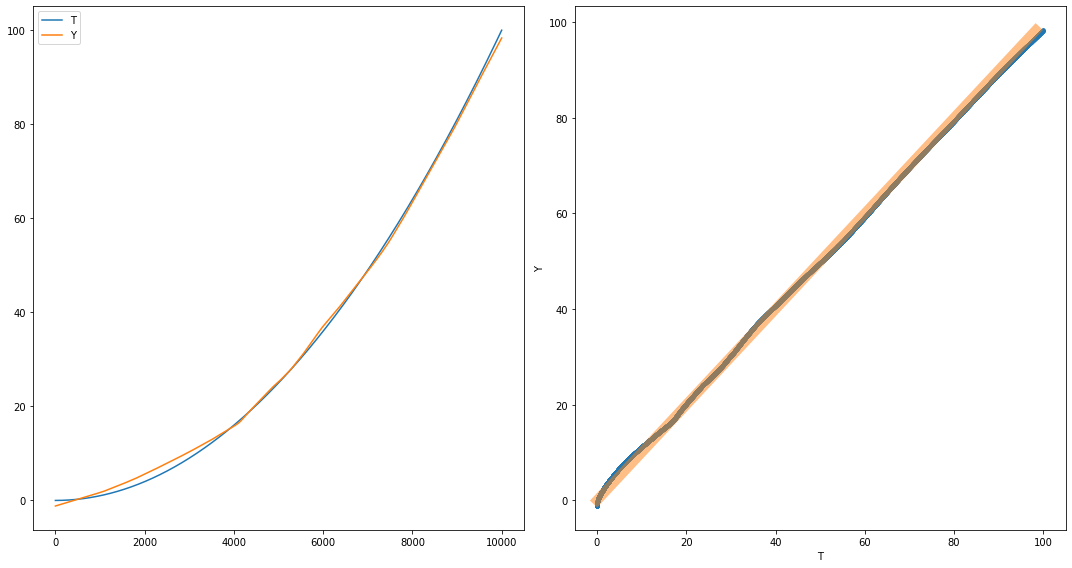

In [48]:
plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.plot(T, label='T')
plt.plot(Y, label='Y')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(T, Y, '.')
a = max(np.min(T), np.min(Y))
b = min(np.max(T), np.max(Y))
plt.plot([a, b], [a, b], lw=10, alpha=0.5)
plt.xlabel('T')
plt.ylabel('Y')
plt.tight_layout()

# Function to generate all train, validate, and test partitions given number of folds

## Implementation

This is complete code for `generate_k_fold_cross_validation_sets`.

In [6]:
def generate_k_fold_cross_validation_sets(X, T, n_folds, shuffle=True):

    if shuffle:
        # Randomly order X and T
        randorder = np.arange(X.shape[0])
        np.random.shuffle(randorder)
        X = X[randorder, :]
        T = T[randorder, :]

    # Partition X and T into folds
    n_samples = X.shape[0]
    n_per_fold = round(n_samples / n_folds)
    n_last_fold = n_samples - n_per_fold * (n_folds - 1)

    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append( (X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]) )
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )

    # Yield k(k-1) assignments of Xtrain, Train, Xvalidate, Tvalidate, Xtest, Ttest

    for validation_i in range(n_folds):
        for test_i in range(n_folds):
            if test_i == validation_i:
                continue

            train_i = np.setdiff1d(range(n_folds), [validation_i, test_i])

            Xvalidate, Tvalidate = folds[validation_i]
            Xtest, Ttest = folds[test_i]
            if len(train_i) > 1:
                Xtrain = np.vstack([folds[i][0] for i in train_i])
                Ttrain = np.vstack([folds[i][1] for i in train_i])
            else:
                Xtrain, Ttrain = folds[train_i[0]]

            yield Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

## Example

In [74]:
X = np.arange(2 * 6).reshape((6, 2))
T = np.arange(6).reshape((6, 1)) * 10
X, T

(array([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11]]),
 array([[ 0],
        [10],
        [20],
        [30],
        [40],
        [50]]))

In [76]:
np.random.seed(42)

for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, 3):
    print()
    print('Xtrain\n', Xtrain)
    print('Ttrain\n', Ttrain)
    print('Xvalidate\n', Xvalidate)
    print('Tvalidate\n', Tvalidate)
    print('Xtest\n', Xtest)
    print('Ttest\n', Ttest)
    


Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[0 1]
 [2 3]]
Tvalidate
 [[ 0]
 [10]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[8 9]
 [6 7]]
Ttrain
 [[40]
 [30]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[10 11]
 [ 4  5]]
Tvalidate
 [[50]
 [20]]
Xtest
 [[8 9]
 [6 7]]
Ttest
 [[40]
 [30]]

Xtrain
 [[10 11]
 [ 4  5]]
Ttrain
 [[50]
 [20]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[0 1]
 [2 3]]
Ttest
 [[ 0]
 [10]]

Xtrain
 [[0 1]
 [2 3]]
Ttrain
 [[ 0]
 [10]]
Xvalidate
 [[8 9]
 [6 7]]
Tvalidate
 [[40]
 [30]]
Xtest
 [[10 11]
 [ 4  5]]
Ttest
 [[50]
 [20]]


# Function to train NNets and average RMSE over all ways of partitioning

## Implementation

Define the following function that trains neural networks of different architectures, given by `list_of_n_hiddens`, for one value each of `n_epochs`, `learning_rate`, and `act_fun`.  For each network, train on all k-fold cross-validation training sets, and calculate the RMSEs for the training, validation and test. Calculate the mean of training, validation and test RMSEs over the k-fold partitions, so that you have one training, one validation, and one test set RMSE for each network.  Append a list of the architecture and these three mean RMSEs to a list of results and return the list as a pandas DataFrame described below when done.

To iterate over all k-fold partitions, use a for loop like the example in the previous code cell. Call `generate_k_fold_cross_validation_sets` with `shuffle=True`. 

In [7]:
def run_k_fold_cross_validation(X, T, n_folds, list_of_n_hiddens, 
                                n_epochs, learning_rate, act_func, use_gpu=False):
    data = []
    for n_hiddens in list_of_n_hiddens:
        training_rmse = 0
        validation_rmse = 0
        test_rmse = 0
        for Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest in generate_k_fold_cross_validation_sets(X, T, n_folds):
            
            n_inputs = X.shape[1]
            n_outputs = T.shape[1]
            
            net = NNet(n_inputs, n_hiddens, n_outputs, act_func, use_gpu=use_gpu)
            
            net.train(Xtrain, Ttrain, n_epochs, learning_rate, verbose=False)
            Ytrain = net.use(Xtrain)
            
            training_rmse += rmse(Ytrain, Ttrain)
            
            Yvalidate = net.use(Xvalidate)
            validation_rmse += rmse(Yvalidate, Tvalidate)
            
            Ytest = net.use(Xtest)
            test_rmse += rmse(Yvalidate, Tvalidate)
        
        training_rmse /= len(list_of_n_hiddens)
        validation_rmse /= len(list_of_n_hiddens)
        test_rmse /= len(list_of_n_hiddens)
        data.append([n_hiddens, training_rmse, validation_rmse, test_rmse])
    data = pandas.DataFrame(data, columns=['Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'])
    return data
            
        

## Apply to Airfoil Data

Download `airfoil_self_noise.dat` from [Airfoil Data Website](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise) and read it as shown below.

In [22]:
airfoil = pandas.read_csv('airfoil_self_noise.dat', delimiter='\t',
                          names=('frequency', 'angle', 'chord', 
                                 'velocity', 'thickness', 'pressure'))

X = np.array(airfoil[['frequency', 'angle', 'chord', 'velocity', 'thickness']])
T = np.array(airfoil[['pressure']])
airfoil

,frequency,angle,chord,velocity,thickness,pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461
...,...,...,...,...,...,...
1498,2500,15.6,0.1016,39.6,0.052849,110.264
1499,3150,15.6,0.1016,39.6,0.052849,109.254
1500,4000,15.6,0.1016,39.6,0.052849,106.604
1501,5000,15.6,0.1016,39.6,0.052849,106.224


Apply your `run_k_fold_cross_validation` to the airfoil data, with `X` being the first five columns of the data and `T` being the last column, the 'pressure'. 

Here is an example run.  You must try more neural network architectures.  Keep the following points in mind when you choose parameter values to try:
* Larger networks will require more epochs of training to converge.
* Large learning rates could limit convergence, but small learning rates may take many more epochs than you have patience for.
* Display results as a `pandas` `DataFrame` and in plots.  <font color=red>Your tabular results and plots must be described sufficiently.  If you struggle with judging this yourself, you can consider 10 sentences or more of discussion to be sufficient, but 9 perceptive sentences are better than 10 or more sentences of non-analytical fluff.</font>
* Name the columns of your `DataFrame` result to be `columns=('Arch', 'Train RMSE', 'Validate RMSE', 'Test RMSE'))`

In [23]:
X.shape, T.shape

((1503, 5), (1503, 1))

In [96]:
torch.manual_seed(42)
np.random.seed(42)

import time
start = time.time()
results_200 = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [100], [40, 50], [200, 200], [50, 50, 50], [200, 200, 200], [90, 60, 60, 30], [50, 50, 50, 50], [200, 200, 200, 200]],
                                      200, 0.01, 'tanh')
results_400 = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [100], [40, 50], [200, 200], [50, 50, 50], [200, 200, 200], [90, 60, 60, 30], [50, 50, 50, 50], [200, 200, 200, 200]],
                                      400, 0.01, 'tanh')
results_600 = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [100], [40, 50], [200, 200], [50, 50, 50], [200, 200, 200], [90, 60, 60, 30], [50, 50, 50, 50], [200, 200, 200, 200]],
                                      600, 0.01, 'tanh')
results_800 = run_k_fold_cross_validation(X, T, 5,
                                      [[], [1], [5], [100], [40, 50], [200, 200], [50, 50, 50], [200, 200, 200], [90, 60, 60, 30], [50, 50, 50, 50], [200, 200, 200, 200]],
                                      800, 0.01, 'tanh')

elapsed = (time.time() - start) / 60/ 60
print(f'Took {elapsed:.2f} hours')
results_200, results_400, results_600, results_800

Took 0.35 hours


(                    Arch  Train RMSE  Validate RMSE  Test RMSE
 0                     []    8.710021       8.798578   8.798578
 1                    [1]    8.217329       8.273407   8.273407
 2                    [5]    7.173252       7.409601   7.409601
 3                  [100]    4.769017       5.222766   5.222766
 4               [40, 50]    2.786204       3.399094   3.399094
 5             [200, 200]    2.349369       3.317011   3.317011
 6           [50, 50, 50]    2.718197       3.317472   3.317472
 7        [200, 200, 200]    1.992164       3.009392   3.009392
 8       [90, 60, 60, 30]    2.238879       3.118340   3.118340
 9       [50, 50, 50, 50]    2.765890       3.493653   3.493653
 10  [200, 200, 200, 200]    2.959542       3.988192   3.988192,
                     Arch  Train RMSE  Validate RMSE  Test RMSE
 0                     []    8.717708       8.746708   8.746708
 1                    [1]    8.096525       8.163855   8.163855
 2                    [5]    6.541156  

Here is a handy function to plot the RMSEs you have in your results table.  You may use this function to plot your results.  Remember to describe what you see.

In [146]:
def plot_results(results):
    errors = results.iloc[:, 1:].values
    archs = results.iloc[:, 0].values
    archs = [str(ar) for ar in archs]

    plt.plot(archs, errors, 'o-')
    plt.legend(('Train', 'Validate', 'Test'))
    plt.ylabel('RMSE')
    plt.xticks(range(errors.shape[0]), archs, rotation=45, ha='right')
    plt.tight_layout()
    
def plot_multiple_results(results_list, title_list):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    for i, (results, title) in enumerate(zip(results_list, title_list)):
        
        thisplot = axs[i // 2, i % 2]
        errors = results.iloc[:, 1:].values
        archs = results.iloc[:, 0].values
        archs = [str(ar) for ar in archs]

        thisplot.plot(archs, errors, 'o-')
        thisplot.legend(('Train', 'Validate', 'Test'))
        
        plt.tight_layout()
        thisplot.set_title(title)
        if i > 1:
            for tick in thisplot.get_xticklabels():
                tick.set_rotation(45)
            
    for ax in axs.flat:
        ax.set(xlabel='Architecture', ylabel='RMSE', ylim=(0.5, 9))

    for ax in axs.flat:
        ax.label_outer()
        


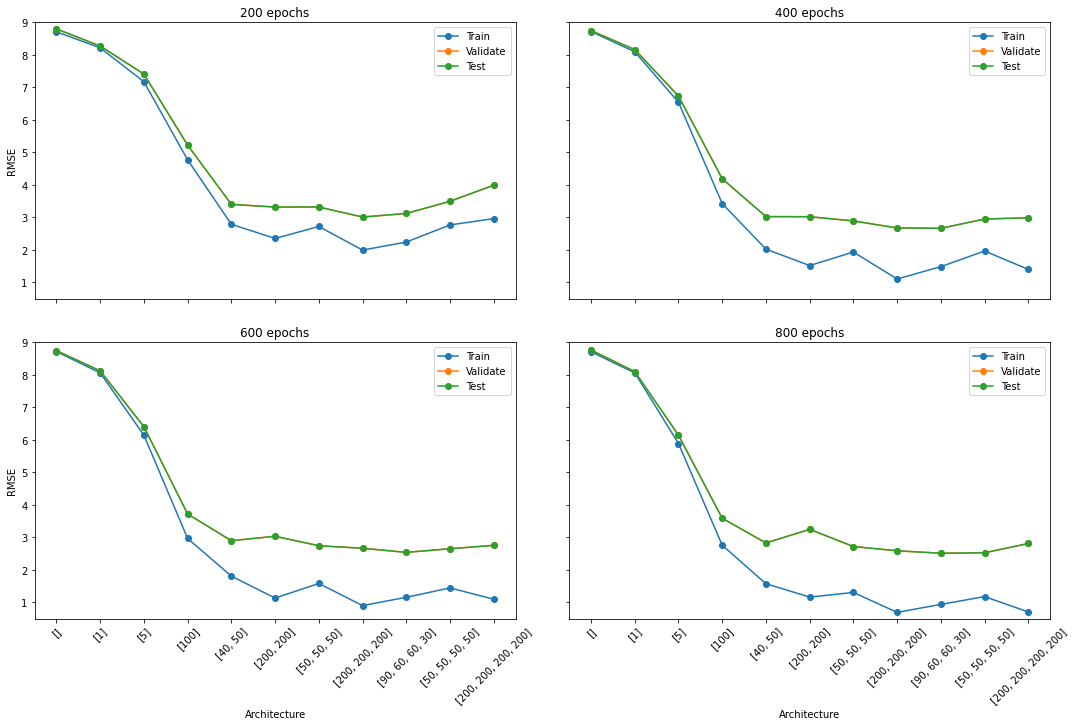

In [147]:
# plot_results(results_200)

plot_multiple_results([results_200,results_400,results_600,results_800],['200 epochs','400 epochs','600 epochs','800 epochs'])

# Analysis of Tabular Results and Plots

I chose the above architectures to provide a brief overview of the results of larger neural nets (ones that merely have more neurons) and those that are deeper (ones that have more hidden layers) and compare the results as the nets become deeper and wider. One point that I added beyond the requested results was a progression of RMSE as we increase the number of epochs of training. This makes it easier to see how long it takes for deeper and wider networks to be trained. It should also be noted that, for the purpose of this experiment, validation and test folds are used identically, and therefore can be treated as nearly identical. The RMSEs for these folds have nearly the same value, which can be seen by the eclipse of the validattion RMSE by the test RMSE.

To begin, I will briefly cover the linear (one-layer) models. These show a clear improvement in RMSE as the number of neurons increase. However, because they represent a linear model, they struggle to perform as well as deper networks. An architecture of [100], for example, has almost a 50% higher training RMSE than [40, 50], despite having more neurons overall. Further increasing the width and depth of the model continues to improve the training RMSE, though the charts show an increased need for training as the model deepens and widens; at only 200 epochs, [50, 50, 50] outperforms [200, 200, 200, 200] in both testing RMSE and training RMSE, but with additional training, the depeer network improves its training RMSE.

However, looking only at training RMSE can be deceptive. As we look at the testing RMSE, we can see very little improvement of test RMSE after the [40, 50] architecture. This may be a result of training; 800 epochs may simply not be enough for some of the deeper, wider networks to really come into their element. However, we still see training RMSE improve over this time. The fact that we see training RMSE continue to improve while test RMSE stagnates is probably due to overtraining; the network becomes better and better adapted to the data it has trained for, at the cost of accuracy when assessing real-world data outside of the set it trained for. We can see this start to take place for the [200, 200] architecture and the [200, 200, 200, 200] architecture between 600 and 800 epochs. For each of these architectures, we see an actual increase in test RMSE over this period, while the latter architecture improves its training RMSE. Thus, we have exceeded the usefulness of a deeper neural network for this dataset. Indeed, as the network gets ever wider and deeper, we even see that some larger networks are outperformed on test RMSE than their simpler counterparts. [50, 50, 50, 50] has a better test RMSE than [200, 200, 200, 200], and [40, 50] either matches or outperforms [200, 200] for every level of training.

Overall, we see swiftly-diminishing returns after the second layer is added. No real improvement (that is, improvement in Test RMSE) can be seen in the deeper networks, which also require additional training in order to remain relevant. Thus, when constructing an effective neural network, one should be careful that their neural network does not outgrow and overconform to the data.

# Grading and Check-In

You will score 90 points if your `train`, `use`, an `run_k_fold_cross_validation` functions are defined correctly. You can test this grading process yourself by downloading [A3grader.zip](https://www.cs.colostate.edu/~cs445/notebooks/A3grader.zip) and extracting `A3grader.py` parallel to this notebook.  We recommend keeping this notebook and the grader script in a dedicated folder with *just those two files.* Run the code in the following cell to see an example grading run.  If your functions are defined correctly, you should see a score of 90/90.  The remaining 10 points will be based on 1) other testing and the results you obtain, and 2) your discussions.

In [25]:
%run -i A3grader.py


======================= Code Execution =======================

Extracting python code from notebook named 'Richard-A3.ipynb' and storing in notebookcode.py
Removing all statements that are not function or class defs or import statements.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='relu')
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(142)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])

    nnet = NNet(X.shape[1], [10, 10], T.shape[1], act_func='tanh')  # Using tanh
    nnet.train(X, T, 100, 0.01, verbose=False)

    first_Y = nnet.use(X)[0, 0]


--- 30/30 points. Returned correct value.

Testing
    torch.manual_seed(400)
    np.random.seed(400)

    X = np.arange(40).reshape(20, 2)
    T = np.log(1 + X[:, 0:1])
    
    results = run_k_f

Unlike A2, A3 **should be completed individually**.  Name your notebook as `Lastname-A3.ipynb` with Lastname being your last name, and then save this notebook and check it in at the A3 assignment link in our Canvas web page.

# Extra Credit

Earn up to 10 extra credit points on this assignment.

1. Add a keyword argument `gpu` that is `False` by default.  If set to `True`, move data and neural network model to the GPU and train and test it there.  Compare total execution time without and with the use of the GPU.  You may need to use one of the campus GPU machines for this.
2. Find another data set, not used previously in an assignment or in lecture, and repeat your training experiment without and with GPU on this new data.

Describe all results.  You can earn 5 points for doing (1) and another 5 for doing (2).

# Extra Credit 1

Here, I am still using the airfoil data to test the GPU speed. For convenience, I am continuing to use run_k_fold_cross_validation, though the relative rmse will not be used in this experiment. I will use test with different sizes of architectures to test relative speedup.

In [30]:
import time
architectures = [[10, 10], [50, 50], [100, 100], [200, 200], [500, 500]]
with_gpu = []
without_gpu = []
for arch in architectures:

    start = time.time()
    results = run_k_fold_cross_validation(X, T, 5,
                                          [arch],
                                          200, 0.01, 'tanh', use_gpu=True)
    elapsed = (time.time() - start) / 60
    with_gpu.append(elapsed)
    
    start = time.time()
    results = run_k_fold_cross_validation(X, T, 5,
                                          [arch],
                                          200, 0.01, 'tanh', use_gpu=False)
    elapsed = (time.time() - start) / 60
    without_gpu.append(elapsed)

with_gpu, without_gpu


([0.07524838050206502,
  0.07468955914179484,
  0.07475218375523886,
  0.07493118047714234,
  0.07687861919403076],
 [0.05270067453384399,
  0.06712033748626708,
  0.07642132838567098,
  0.11015535593032837,
  0.3335632006327311])

Just from the output lists, we already see an interesting trend: when using the GPU, even the largest architecture takes little more time than the smallest. However, the CPU wins out against the GPU for small architectures (due to the overhead of using the GPU), only to be defeated for the larger architecture. This difference can be seen in the charts below.

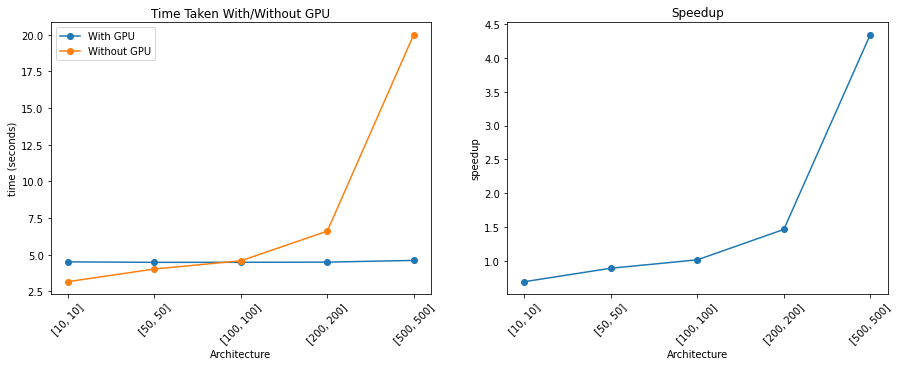

In [40]:
def plot_ec1(with_gpu, without_gpu, archs):
    with_gpu = [t*60 for t in with_gpu]
    without_gpu = [t*60 for t in without_gpu]
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    archs = [str(ar) for ar in archs]
    speedup = []
    for w, wo in zip(with_gpu, without_gpu):
        speedup.append(wo / w)
    
    axs[0].plot(archs, with_gpu, 'o-')
    axs[0].plot(archs, without_gpu, 'o-')
    axs[0].legend(('With GPU', 'Without GPU'))
    axs[0].set_title('Time Taken With/Without GPU')
    
    axs[1].plot(archs, speedup, 'o-')
    axs[1].set_title('Speedup')
    
    for ax in axs:
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)
            
    
    axs[0].set(xlabel='Architecture', ylabel='time (seconds)')
    axs[1].set(xlabel='Architecture', ylabel='speedup')

plot_ec1(with_gpu, without_gpu, architectures)

Of course, most applications will use very large amounts of data and very large networks (at least compared to a [50, 50] network). Thus, GPUs are incredibly important in machine learning.

# Extra Credit 2

I used the [Wave Energy Converters Data Set](https://archive.ics.uci.edu/ml/datasets/Wave+Energy+Converters) for this part of the assignment. For simplicity, I'm only using the dataset for wave energy converters on the coast of Sydney.

This dataset was chosen for its large size, to showcase the value of using a GPU.

For this experiment, I will only use one architecture ([200, 200]) in order to reduce training time.

In [10]:
data = pandas.read_csv('Sydney_Data.csv', delimiter=',',
                       names=('X1','Y1',  # Wave converter coordinates
                              'X2','Y2',
                              'X3','Y3',
                              'X4','Y4',
                              'X5','Y5',
                              'X6','Y6',
                              'X7','Y7',
                              'X8','Y8',
                              'X9','Y9',
                              'X10','Y10',
                              'X11','Y11',
                              'X12','Y12',
                              'X13','Y13',
                              'X14','Y14',
                              'X15','Y15',
                              'X16','Y16',
                              'P1','P2',  # Wave converter power outputs
                              'P3','P4',
                              'P5','P6',
                              'P7','P8',
                              'P9','P10',
                              'P11','P12',
                              'P13','P14',
                              'P15','P16',
                              'powerall'))  # Total power output


# I could probably use this dataset to predict only powerall, but it would be more interesting to
# see this network perform with multiple outputs. Never you mind that this exercise doesn't ask
# that I measure the RMSE.

X = np.array(data[['X1','Y1',
                    'X2','Y2',
                    'X3','Y3',
                    'X4','Y4',
                    'X5','Y5',
                    'X6','Y6',
                    'X7','Y7',
                    'X8','Y8',
                    'X9','Y9',
                    'X10','Y10',
                    'X11','Y11',
                    'X12','Y12',
                    'X13','Y13',
                    'X14','Y14',
                    'X15','Y15',
                    'X16','Y16',]])
T = np.array(data[['P1','P2',
                  'P3','P4',
                  'P5','P6',
                  'P7','P8',
                  'P9','P10',
                  'P11','P12',
                  'P13','P14',
                  'P15','P16',
                  'powerall']])

X, T

(array([[127.9439, 264.9656,  68.3481, ..., 229.8789, 143.6402, 256.6052],
        [500.4677, 278.6497,  47.4062, ...,  96.7684,  90.1294, 364.7503],
        [511.751 , 104.4383, 566.    , ..., 117.445 , 411.2962, 566.    ],
        ...,
        [564.7783, 566.    , 564.7783, ..., 566.    ,   0.    ,  90.535 ],
        [566.    , 556.6139, 551.3846, ..., 566.    , 364.7285, 552.225 ],
        [566.    , 556.6139, 551.3846, ..., 566.    , 364.7285, 501.0031]]),
 array([[  82808.443 ,   84478.9266,   85337.6466, ...,  103129.6938,
           97196.8128, 1463622.174 ],
        [  94549.5866,   84592.1988,   99335.5046, ...,   94499.479 ,
           88941.7152, 1489888.502 ],
        [  93365.954 ,   87177.9348,   92796.2067, ...,  100646.9126,
           83394.8729, 1495035.934 ],
        ...,
        [ 107528.0982,  102635.1173,  101060.1999, ...,   99995.2627,
           91501.2131, 1529778.256 ],
        [ 107227.8748,  101483.4118,   99759.6914, ...,   90513.6759,
           87173.861

In [17]:
import time
start = time.time()
results = run_k_fold_cross_validation(X, T, 5,
                                      [[200, 200]],
                                      200, 0.01, 'tanh', use_gpu=True)
elapsed_with_gpu = (time.time() - start) / 60
start = time.time()
results = run_k_fold_cross_validation(X, T, 5,
                                      [[200, 200]],
                                      200, 0.01, 'tanh', use_gpu=False)
elapsed_without_gpu = (time.time() - start) / 60

print(f"Without the gpu, the network took {elapsed_without_gpu:.2f} minutes.")
print(f"With the gpu, the network took {elapsed_with_gpu:.2f} minutes.")
print(f"\nThus, we have a speedup of {elapsed_without_gpu / elapsed_with_gpu:.2f}.")

Without the gpu, the network took 5.43 minutes.
With the gpu, the network took 0.71 minutes.

Thus, we have a speedup of 7.69.


This speedup (about 7.7) is considerably better than what we saw with the airfoil data (about 1.5) using this architecture, thus proving my hypothesis that a much larger dataset would benefit more from the GPU. This was not a radical hypothesis, of course, as it was stated clearly in the lecture.

Just for the sake of curiosity, I'll check the results. They should be approximately the same with each of these, so it doesn't matter that I'm looking at the results of the neural network without the GPU.

In [18]:
results

,Arch,Train RMSE,Validate RMSE,Test RMSE
0,"[200, 200]",80005.460939,85106.657311,85106.657311


In [21]:
percent_difference = 85106.657311 / 1486228.972 * 100
percent_difference

5.726348961995608

That RMSE looks terrible at first glance! However, the average value for powerall (which will, of course, have the highest values) is 1486228.972. That makes this test RMSE account for about a 5.7%  error.

It should be noted, however, that the actual error is much higher, because the output variables also include 16 different power outputs that sum up to powerall. To obtain a more accurate RMSE, this calculation would need to be separate for each power column. A standardized RMSE might be more effective for such an application, as it could present a percent difference rather than a difference in the total value. Overall, this likely bears more investigation that could be fruitful for me, but it would also take away much-needed time for my other classes when I've already exceeded the scope of this extra credit question.